In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import os
from tqdm import tqdm
tqdm.pandas()
print(os.listdir("../input"))

['embeddings', 'sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

print(f'Train shape: {df_train.shape}')
print(f'Test shape: {df_test.shape}')

Train shape: (1306122, 3)
Test shape: (375806, 2)


In [3]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
df = pd.concat([df_train,df_test],sort=True)

df.shape

(1681928, 3)

In [5]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

Let's Load Glove Embedding

In [6]:
embedding = load_embed('../input/embeddings/glove.840B.300d/glove.840B.300d.txt')

Now we should build our vocab keeping the frequency of each word in the vocab

In [7]:
from collections import defaultdict

def build_vocab(sentences):
    fd = defaultdict(int)
    for sentence in tqdm(sentences):
        for word in sentence:
            fd[word]+=1
    return fd    

Let's create a function to check how many words in our vocab are actually present in out embedding

In [8]:
def embed_intersection(vocab,embedding):
    temp = {}
    oov = {}
    i = 0
    j = 0
    
    for word in vocab.keys():
        try:
            temp[word] = embedding[word]
            i+=vocab[word]
        except:
            oov[word] = vocab[word]
            j+=vocab[word]
            pass
    
    print(f"Found embeddings for {(len(temp)/len(vocab)*100):.3f}% of vocab")
    print(f"Found embeddings for {(i/(i+j))*100:.3f}% of all text")
    
    sorted_x = sorted(oov.items(), key = lambda x: x[1])[::-1]
    return sorted_x

In [9]:
sentences = df['question_text'].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
oov = embed_intersection(vocab,embedding)

100%|██████████| 1681928/1681928 [00:06<00:00, 256703.54it/s]


Found embeddings for 31.537% of vocab
Found embeddings for 88.155% of all text


In [10]:
oov[0:10]

[('India?', 21063),
 ('it?', 16623),
 ("What's", 16104),
 ('do?', 11211),
 ('life?', 9993),
 ('you?', 8083),
 ('me?', 7982),
 ('them?', 7910),
 ('time?', 7379),
 ('world?', 6941)]

Due to presence of capital letters some words might not be matching with the embeddings, we should convert them to lower case words

In [11]:
df['lower_que'] = df['question_text'].apply(lambda x: x.lower())

But making the words in lower case can lead to loss of information as there are words whose embeddings are present in upper case only.

We can fix this:
* word.lower() takes the embedding of word if word.lower() doesn't have an embedding

In [12]:
def fix_case(embedding,vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:
            embedding[word.lower()] = embedding[word]
            count +=1
    print(f'{count} no of words inserted into embedding')

In [13]:
oov = embed_intersection(vocab,embedding)
fix_case(embedding,vocab)
oov = embed_intersection(vocab,embedding)

Found embeddings for 31.537% of vocab
Found embeddings for 88.155% of all text
17744 no of words inserted into embedding
Found embeddings for 31.820% of vocab
Found embeddings for 88.171% of all text


In [14]:
gc.collect()
oov[0:10]

[('India?', 21063),
 ('it?', 16623),
 ("What's", 16104),
 ('do?', 11211),
 ('life?', 9993),
 ('you?', 8083),
 ('me?', 7982),
 ('them?', 7910),
 ('time?', 7379),
 ('world?', 6941)]

We can see that the punctuations and contractions are causing the mismatch between our vocab and embeddings

In [15]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                       "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not",
                       "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                       "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                       "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  
                       "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                       "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                       "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                       "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                       "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                       "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                       "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                       "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                       "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                       "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", 
                       "that's": "that is", "there'd": "there would", "there'd've": "there would have", 
                       "there's": "there is", "here's": "here is","they'd": "they would", 
                       "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", "they've": 
                       "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
                       "what'll've": "what will have", "what're": "what are",  "what's": "what is", 
                       "what've": "what have", "when's": "when is", "when've": "when have", 
                       "where'd": "where did", "where's": "where is", "where've": "where have", 
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", 
                       "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                       "you'd've": "you would have", "you'll": "you will", 
                       "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [16]:
def cont_map(embedding):
    known = []
    for cont in contraction_mapping:
        if cont in embedding:
            known.append(cont)
    return known

In [17]:
cont_map(embedding)

["can't",
 "'cause",
 "didn't",
 "doesn't",
 "don't",
 "I'd",
 "I'll",
 "I'm",
 "I've",
 "i'd",
 "i'll",
 "i'm",
 "i've",
 "it's",
 "ma'am",
 "o'clock",
 "that's",
 "you'll",
 "you're"]

It can be seen that not all contractions are present in the embeddings, we will now be replacing them

In [18]:
def fix_cont(sentence,mapping):
    sentence = str(sentence)
    specials = ["’", "‘", "´", "`"]
    for each in specials:
        sentence = sentence.replace(each,"'")
    sentence = " ".join([mapping[word] if word in mapping else word for word in sentence.split(" ")])
    return sentence

In [19]:
df['fixed_question'] = df['lower_que'].apply(lambda x: fix_cont(x,contraction_mapping))

In [20]:
sentences = df['fixed_question'].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
oov = embed_intersection(vocab,embedding)

100%|██████████| 1681928/1681928 [00:06<00:00, 265730.08it/s]


Found embeddings for 29.302% of vocab
Found embeddings for 88.570% of all text


**Now it's time to deal with puncuations and special characters**

In [21]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

Let's check which of the punct. are present in GloVe

In [22]:
def unknown_punct(embed, punct):
    unknown = []
    for p in punct:
        if p not in embed:
            unknown.append(p)
    return unknown

In [23]:
print('Unknown Puctuations')
print(unknown_punct(embedding,punct))

Unknown Puctuations
['“', '”', '’', '∞', 'θ', '÷', 'α', '•', 'à', '−', 'β', '∅', '³', 'π', '‘', '₹', '´', '°', '£', '€', '×', '™', '√', '²', '—', '–']


1. Let's replace these with the known ones and for the known ones add a space between word and punctuation

In [24]:
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ",
                 "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", 
                 '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 
                 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

def fix_punt(sentence,punct,mapping):
    for p in mapping:
        sentence = sentence.replace(p, mapping[p])
    
    for p in punct:
        sentence = sentence.replace(p, f' {p} ')
        
    return sentence

In [25]:
df['fixed_question'] = df['fixed_question'].apply(lambda x: fix_punt(x,punct,punct_mapping))

sentences = df['fixed_question'].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
oov = embed_intersection(vocab,embedding)

100%|██████████| 1681928/1681928 [00:06<00:00, 269291.66it/s]


Found embeddings for 66.284% of vocab
Found embeddings for 99.565% of all text


In [26]:
oov[:50]

[('quorans', 1064),
 ('brexit', 682),
 ('cryptocurrencies', 626),
 ('redmi', 488),
 ('…', 337),
 ('oneplus', 177),
 ('coinbase', 176),
 ('uceed', 152),
 ('demonetisation', 148),
 ('bhakts', 145),
 ('upwork', 142),
 ('pokémon', 142),
 ('machedo', 141),
 ('boruto', 136),
 ('adityanath', 132),
 ('gdpr', 130),
 ('bnbr', 126),
 ('alshamsi', 123),
 ('sjws', 116),
 ('iiest', 115),
 ('unacademy', 113),
 ('litecoin', 110),
 ('dceu', 109),
 ('tensorflow', 104),
 ('zerodha', 100),
 ('qoura', 98),
 ('lnmiit', 91),
 ('fiancé', 90),
 ('nicmar', 89),
 ('kavalireddi', 86),
 ('muoet', 85),
 ('doklam', 81),
 ('vajiram', 80),
 ('etc…', 78),
 ('elitmus', 73),
 ('altcoin', 72),
 ('altcoins', 72),
 ('jiren', 71),
 ('awdhesh', 71),
 ('adhaar', 70),
 ('hackerrank', 68),
 ('srmjee', 68),
 ('zebpay', 68),
 ('baahubali', 63),
 ('koinex', 60),
 ('mhcet', 58),
 ('byju', 58),
 ('binance', 58),
 ('ryzen', 58),
 ('beerus', 54)]

What's still missing ?
* Unknown words
* Acronyms
* Spelling mistake

Now we will fix some of the common mispellings and acronyms to further improve our intersection of vocab with embeddings

Some of the common mispellings

In [27]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 
                'travelling': 'traveling', 'counselling': 'counseling', 
                'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 
                'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 
                'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 
                'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much',
                'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 
                'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', 
                "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018',
                'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', 
                "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 
                'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'pokémon': 'pokemon','redmi': 'company','oneplus':'company','bhakts':'Worshippers','…': '...'}

In [28]:
def fix_spellings(sentence,mapping):
    for word in mapping.keys():
        sentence = sentence.replace(word,mapping[word])
    return sentence

In [29]:
df['fixed_question'] = df['fixed_question'].apply(lambda x: fix_spellings(x,mispell_dict))

sentences = df['fixed_question'].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
oov = embed_intersection(vocab,embedding)

gc.collect()

100%|██████████| 1681928/1681928 [00:06<00:00, 261480.24it/s]


Found embeddings for 66.282% of vocab
Found embeddings for 99.572% of all text


0

Applying all the changes to test and train set

In [30]:
df_train['fix_ques'] = df_train['question_text'].apply(lambda x: x.lower())
df_train['fix_ques'] = df_train['fix_ques'].apply(lambda x: fix_cont(x,contraction_mapping))
df_train['fix_ques'] = df_train['fix_ques'].apply(lambda x: fix_punt(x,punct,punct_mapping))
df_train['fix_ques'] = df_train['fix_ques'].apply(lambda x: fix_spellings(x,mispell_dict))

df_test['fix_ques'] = df_test['question_text'].apply(lambda x: x.lower())
df_test['fix_ques'] = df_test['fix_ques'].apply(lambda x: fix_cont(x,contraction_mapping))
df_test['fix_ques'] = df_test['fix_ques'].apply(lambda x: fix_punt(x,punct,punct_mapping))
df_test['fix_ques'] = df_test['fix_ques'].apply(lambda x: fix_spellings(x,mispell_dict))

Now the embeddings covers almost all of our text data Yay!!

It's time to build the model

In [31]:
del df

In [32]:
vocab_size = len(vocab) + 1
max_len = 65

In [33]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [34]:
def process_data(data):
    t = Tokenizer(filters='')
    t.fit_on_texts(data)
    data = t.texts_to_sequences(data)
    data = pad_sequences(data,maxlen = max_len)
    return data, t.word_index,t

In [35]:
X, word_index, tokenizer = process_data(df_train['fix_ques'])

Let's make our train and CV sets

In [36]:
from sklearn.model_selection import train_test_split

y = df_train['target'].values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42)

In [38]:
X_train.shape

(1175509, 65)

Let's make our embedding matrix

In [39]:
def make_embed_mat(embedding,word_index,vocab_size):
    embds = np.stack(embedding.values())
    emb_mean,emb_std = embds.mean(), embds.std()
    embed_size = embds.shape[1]
    word_index = word_index
    embedding_matrix = np.random.normal(emb_mean,emb_std,(vocab_size,embed_size))
    
    for word,i in word_index.items():
        if i>=vocab_size:
            continue
        embedding_vec = embedding.get(word)
        if embedding_vec is not None:
            embedding_matrix[i] = embedding_vec
    return embedding_matrix

In [40]:
embed_matrix = make_embed_mat(embedding,word_index,vocab_size)
del word_index
gc.collect()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


10

In [41]:
embed_matrix.shape

(226466, 300)

In [42]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [43]:
from keras.layers import Dense, Embedding, CuDNNGRU, Bidirectional, GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D,concatenate,Input, Dropout
from keras.optimizers import Adam
from keras.models import Model

In [44]:
def make_model(embedding_matrix, embed_size=300, loss='binary_crossentropy'):
    inp = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size,output_dim=embed_size,weights=[embedding_matrix],trainable=False)(inp)
    x = Bidirectional(CuDNNGRU(128,return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    avg_pl = GlobalAveragePooling1D()(x)
    max_pl = GlobalMaxPooling1D()(x)
    concat = concatenate([avg_pl,max_pl])
    dense  = Dense(64, activation="relu")(concat)
    dense   = Dropout(rate = 0.7)(dense)
    output = Dense(1, activation="sigmoid")(dense)
    
    model = Model(inputs=inp, output=output)
    model.compile(loss=loss,optimizer=Adam(lr=0.0001), metrics=['accuracy', f1])
    return model

In [45]:
model = make_model(embed_matrix)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


In [46]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 65)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 65, 300)      67939800    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 65, 256)      330240      embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 65, 128)      123648      bidirectional_1[0][0]            
__________________________________________________________________________________________________
global_ave

In [47]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [48]:
checkpoints = ModelCheckpoint('model.h5',monitor='val_f1',mode='max',save_best_only='True',verbose=True)
reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, verbose=1, min_lr=0.000001)

In [49]:
epochs = 10
batch_size = 128


In [50]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=[X_test, y_test], callbacks=[checkpoints, reduce_lr])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1175509 samples, validate on 130613 samples
Epoch 1/10
1175509/1175509 [==============================] - 201s 171us/step - loss: 0.1309 - acc: 0.9509 - f1: 0.4875 - val_loss: 0.1086 - val_acc: 0.9565 - val_f1: 0.6026

Epoch 00001: val_f1 improved from -inf to 0.60260, saving model to model.h5
Epoch 2/10
 876160/1175509 [=====================>........] - ETA: 48s - loss: 0.1152 - acc: 0.9558 - f1: 0.5652

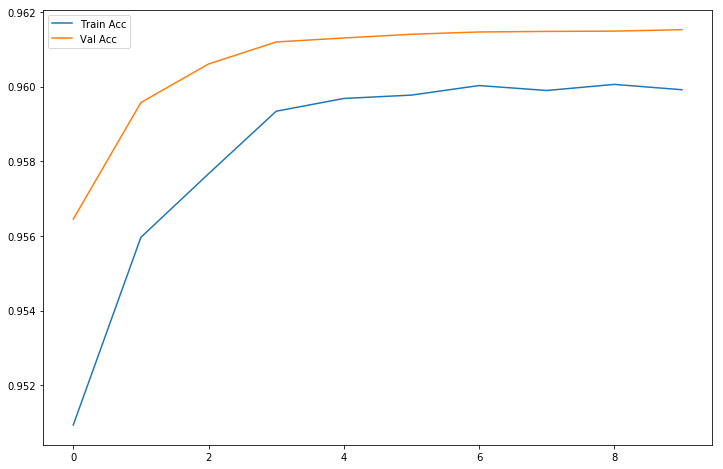

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.legend(('Train Acc', 'Val Acc'))
plt.show()

In [52]:
model.load_weights('model.h5')

In [53]:
pred = model.predict(X_test,batch_size=512, verbose=1)

130613/130613 [==============================] - 4s 33us/step


In [54]:
from sklearn.metrics import f1_score

def tweak_threshold(pred, truth):
    thresholds = []
    scores = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        thresholds.append(thresh)
        score = f1_score(truth, (pred>thresh).astype(int))
        scores.append(score)
    return np.max(scores), thresholds[np.argmax(scores)]

In [55]:
score_val, threshold_val = tweak_threshold(pred, y_test)

print(f"Scored {round(score_val, 4)} for threshold {threshold_val} with treated texts on validation data")

Scored 0.6779 for threshold 0.42 with treated texts on validation data


In [56]:
test = tokenizer.texts_to_sequences(df_test['fix_ques'])
test = pad_sequences(test,maxlen = max_len)

gc.collect()

0

In [57]:
pred_test = model.predict(test,batch_size=512, verbose=1)

375806/375806 [==============================] - 12s 31us/step


In [58]:
df_test['prediction'] = (pred_test>0.39).astype(int)

In [59]:
df_test.head()

,qid,question_text,fix_ques,prediction
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...,why do so many women become so rude and arroga...,1
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...,when should i apply for rv college of engineer...,0
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...,what is it really like to be a nurse practitio...,0
3,000086e4b7e1c7146103,Who are entrepreneurs?,who are entrepreneurs ?,0
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?,is education really making good people nowaday...,0


In [60]:
sub = df_test.drop(labels=['question_text','fix_ques'],axis=1)

In [61]:
sub.to_csv(path_or_buf='submission.csv',index=False)